In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from pandas.plotting import scatter_matrix
from scipy.spatial import ConvexHull

from datetime import datetime, timedelta, date

np.random.seed(0)

In [2]:
!pip install pykrx
from pykrx import stock

In [3]:
!pip install -U finance-datareader
import FinanceDataReader as web
print(web.__version__)

0.9.50


In [4]:
# 데이터 가져오기

def stock_reader(kospi_df, stock_name, code_list, df='p', n=0):

    if n == 0:
        n = len(code_list)

    stock_df = pd.DataFrame()
    stock_df['Date'] = kospi_df['Date']
    print("동기간 KOSPI 생성일수 : ", len(kospi_df['Date']))
    normal_cnt = 0
    err_cnt = 0
    code_nm_list = []
    symbol_list = []
    
    print("n", n)

    for code in code_list:
        stock = df_krx[df_krx.Code == code]
        code_nm = list(stock.Name)[0]
        symbol = list(stock.Code)[0]


        try:
            temp = web.DataReader(code, start_date, end_date)

            # 데이터일수가 시장보다 작으면 skip(최근 상장 데이터로 판단)
            if len(temp) < len(kospi_df['Date']):
                err_cnt += 1
                print("skip : (",err_cnt,")", code_list[code], code_nm, start_date, end_date, ", 건수 : ", len(temp))
                continue

            temp.reset_index(inplace = True)
            temp_df = pd.merge(temp[['Date','Close', 'Open']], kospi_df[['Date']], on='Date', how='right')

            if df == 'v':
                stock_df[code_nm] = temp_df.Close - temp_df.Open #variation
            elif df == 'p':
                stock_df[code_nm] = temp_df.Close # price

            normal_cnt += 1
            code_nm_list.append(code_nm)
            symbol_list.append(symbol)
            print("정상 : (",normal_cnt,")", code, code_nm, start_date, end_date, ", 건수 : ", len(temp), "->", len(stock_df))
        except:
            err_cnt += 1
            print("skip : (",err_cnt,")", code, code_nm, start_date, end_date, ", 건수 : ", len(temp))

        if normal_cnt == n:
            print('총', n,'개 생성 설정 / ', normal_cnt, '개 생성 완료')
            break # n개 종목 생성시 종료

        # 데이터 정렬
        stock_df.sort_values('Date', ascending=True, inplace=True) # ascending=True 오름차순, False 내림차순
        # 결측치 채우기
        stock_df.fillna(method='ffill', inplace=True)

    return stock_df, code_nm_list, symbol_list

In [5]:
num_stock = int(input()) # 생성할 종목수 지정
stock_name = []

for i in range(num_stock):
    stock_name.append(input()) # 종목 이름 종목 수만큼 입력

code_list = [] # 종목 코드 리스트
tickers = stock.get_market_ticker_list(market="KOSPI")
for i in range(num_stock):
    for ticker in tickers:
        if stock_name[i] == stock.get_market_ticker_name(ticker):
            code_list.append(ticker)
            
print(code_list)

3
삼성전자
카카오
대한항공
['005930', '035720', '003490']


In [6]:
start_date = date.today() - timedelta(days=366)
end_date = date.today() - timedelta(days=1)

print(start_date, end_date)
print(web.__version__)

# 한국 거래소 상장종목 전체
# 용도 : 코드와 종목명 가져오기
df_krx = web.StockListing('KRX')
print(df_krx)

kospi_df = web.DataReader('KS11', start_date, end_date)
kospi_df.reset_index(inplace = True)

2021-11-15 2022-11-15
0.9.50
        Code        ISU_CD      Name Market   Dept   Close ChangeCode  \
0     005930  KR7005930003      삼성전자  KOSPI          62200          2   
1     373220  KR7373220003  LG에너지솔루션  KOSPI         599000          1   
2     000660  KR7000660001    SK하이닉스  KOSPI          91300          2   
3     207940  KR7207940008  삼성바이오로직스  KOSPI         880000          2   
4     051910  KR7051910008      LG화학  KOSPI         704000          2   
...      ...           ...       ...    ...    ...     ...        ...   
2666  288490  KR7288490006     나라소프트  KONEX  일반기업부      63          5   
2667  267810  KR7267810000        앙츠  KONEX  일반기업부    1315          1   
2668  215050  KR7215050006   비엔디생활건강  KONEX  일반기업부     912          0   
2669  267060  KR7267060002     명진홀딩스  KONEX  일반기업부     181          0   
2670  329020  KR7329020002      오션스톤  KONEX  일반기업부    1800          0   

      Changes  ChagesRatio    Open    High     Low   Volume        Amount  \
0        -200    

In [7]:
stock_df, code_nm_list, symbol_list = stock_reader(kospi_df, stock_name, code_list, 'p', num_stock) # v :variation, p : price(close)

동기간 KOSPI 생성일수 :  245
n 3
정상 : ( 1 ) 005930 삼성전자 2021-11-15 2022-11-15 , 건수 :  248 -> 245
정상 : ( 2 ) 035720 카카오 2021-11-15 2022-11-15 , 건수 :  248 -> 245
정상 : ( 3 ) 003490 대한항공 2021-11-15 2022-11-15 , 건수 :  248 -> 245
총 3 개 생성 설정 /  3 개 생성 완료


In [8]:
stock_df.dropna(inplace=True)
data = stock_df.set_index('Date')

print(data)

             삼성전자     카카오   대한항공
Date                            
2021-11-15  71400  129000  30400
2021-11-16  71300  127500  30450
2021-11-17  70700  125000  29850
2021-11-18  70200  124500  29400
2021-11-19  71200  127000  29650
...           ...     ...    ...
2022-11-08  61800   51500  24650
2022-11-09  62000   52100  24700
2022-11-10  60400   50800  24550
2022-11-11  62900   58700  26500
2022-11-14  61900   58500  25800

[245 rows x 3 columns]


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
c:\users\yeeju\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\yeeju\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\yeeju\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\yeeju\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\yeeju\app

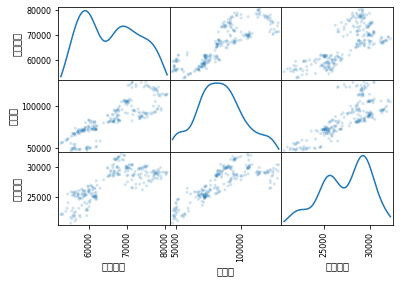

In [9]:
# 종목별 상관계수
scatter_matrix(data, alpha=0.2, diagonal='kde')
plt.show()

In [10]:
# 현재 포트폴리오 설정 (랜덤 Weight로 산출)
num_assets = np.size(code_nm_list)
cur_value = (1e4-5e3)*np.random.rand(num_assets,1) + 5e3        
tot_value = np.sum(cur_value)
weights = cur_value.ravel()/float(tot_value)
print(weights)

[0.31824284 0.35242896 0.3293282 ]


In [11]:
#compute portfolio risk
Sigma = data.cov().values
Corr = data.corr().values

print(np.dot(Sigma, weights))
volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))

[7.03460340e+07 2.12704675e+08 2.28061781e+07]


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


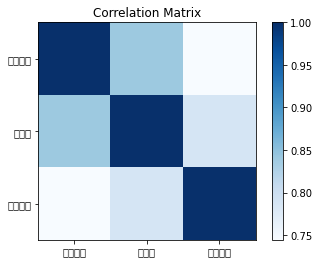

In [12]:
# 종목별 상관관계 Matrix
plt.figure()
plt.title('Correlation Matrix')        
plt.imshow(Corr, cmap=plt.cm.Blues)
plt.xticks(range(len(code_nm_list)),data.columns)
plt.yticks(range(len(code_nm_list)),data.columns)    
plt.colorbar()
plt.show()

In [13]:
# 각 자산의 평균 가격을 기준으로 무작위 Weight를 지정한다.

num_trials = 1000
W = np.random.rand(num_trials, np.size(weights))    
W = W/np.sum(W,axis=1).reshape(num_trials,1)  #normalize

pv = np.zeros(num_trials)   #portoflio value  w'v
ps = np.zeros(num_trials)   #portfolio sigma: sqrt(w'Sw)

avg_price = data.mean().values
adj_price = avg_price

for i in range(num_trials):
    pv[i] = np.sum(adj_price * W[i,:])
    ps[i] = np.sqrt(np.dot(W[i,:].T, np.dot(Sigma, W[i,:])))

points = np.vstack((ps,pv)).T
hull = ConvexHull(points)

In [14]:
# plt.figure()
# plt.scatter(ps, pv, marker='o', color='b', linewidth = '3.0', label = 'tangent portfolio')
# plt.scatter(volatility, np.sum(adj_price * weights), marker = 's', color = 'r', linewidth = '3.0', label = 'current')
# plt.plot(points[hull.vertices,0], points[hull.vertices,1], linewidth = '2.0')    
# plt.title('expected return vs volatility')
# plt.ylabel('expected price')
# plt.xlabel('portfolio std dev')
# plt.legend()
# plt.grid(True)
# plt.show()

In [15]:
knn = 5    
kdt = KDTree(points)
query_point = np.array([80000, 60000]).reshape(1,-1) # 위 그래프에서 현재 포인트(red)를 지정한다.
kdt_dist, kdt_idx = kdt.query(query_point,k=knn)
print("top-%d closest to query portfolios:" %knn)
print("values: ", pv[kdt_idx.ravel()])
print("sigmas: ", ps[kdt_idx.ravel()])

top-5 closest to query portfolios:
values:  [75660.7236792  75113.4765173  77942.89888245 83646.7764135
 81028.63315093]
sigmas:  [17840.83166146 17705.48607135 18443.3035328  20218.07842545
 19069.90618183]


In [35]:
marko_dict = {"markowitz":{"stk_nm":num_stock, "stk_cd":code_list, "stk_wt":weight_list}}
print(marko_dict)

{'markowitz': {'stk_nm': 3, 'stk_cd': ['005930', '035720', '003490'], 'stk_wt': [0.31824283836975004, 0.3524289599179429, 0.32932820171230703]}}


In [36]:
import json

marko_json = json.dumps(marko_dict, indent=4)
print(marko_json)

{
    "markowitz": {
        "stk_nm": 3,
        "stk_cd": [
            "005930",
            "035720",
            "003490"
        ],
        "stk_wt": [
            0.31824283836975004,
            0.3524289599179429,
            0.32932820171230703
        ]
    }
}
